# Rideshare Data Analysis

***Objective:*** 
This analysis aims to uncover insights from rideshare data, leveraging the power of the pandas library alongside other essential libraries such as seaborn and matplotlib. By using pandas, we can significantly accelerate data processing tasks compared to standard Python code. Additionally, ensuring that each column in the dataset has the appropriate data type enhances the effectiveness of the analysis.

The ability to generate insightful visualizations through plotting can elevate the analysis to a new level. In this context, we employ seaborn and matplotlib to create meaningful and informative plots that aid in understanding the data.

The focus of this analysis is to answer key questions related to a rider's journey. By addressing these fundamental questions, we aim to provide a clear understanding of the rideshare experience. The analysis includes:

**Data Cleaning and Preparation:** Ensuring the dataset is clean and the data types are correctly set for efficient processing.

**Descriptive Statistics:** Summarizing the main features of the dataset to get an initial understanding.

**Visual Analysis:** Utilizing seaborn and matplotlib to create visualizations that highlight important trends and patterns in the data.
This structured approach will provide valuable insights into the rideshare data, making it easier to understand the dynamics of a rider's journey.

**Reference:** Techniques, stylings and codes are written primarily following two resources-

1. Matt Harrison's book, 'EFFECTIVE PANDAS'
2. Applied Data Science Lab from WorldQuant University

Let's begin with importing the necessary libraries!

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import warnings


Changing the rendering mode so the plotly graphs can be seen in the notebook. Silece the User warnings

In [26]:
import plotly.io as pio
warnings.simplefilter("ignore", UserWarning)

## Data Wrangling

Its a good practice to code in an organized manner and I love to follow it. Therefore, before diving into analysis, let's wrangle and clean our dataset and focus on the intended areas. I will have a docstring that will tell you what I'm doing using the 'wrangle' function below.

In [95]:
def wrangle(filename):
    
    # Create a docstring to list what this function will do
    
    """A function that will:
          1. Read the data into a dataframe from a zipped file which will contain a single CSV file.
          2. Create a mask to include observations only for the city of Dhaka.
          3. Rename columns for better readability.
          4. Convert the time information columns to timestamps and localize them for Asia/Dhaka Time zone.
          5. Handle missing values for the Fare Amount column.
          6. Convert columns to appropiate data types, such as 'category'.
          7. In Bangladesh, distance usually mesaured in kilometers (km). Convert miles to km.
          8. The column 'Products' needs cleaning. Clean it accordingly.
          9. Make four categories of different services , Pouplar, Economy, Premier and Others.
          10. Create a duration of trips column. The duration should be in minutes.
          11. Create another column to indicate the time of the trip, i.e: Night/Morning/Afternoon
          12. Delete the redundant columns, if any.
          13. Filtering erroneous address entries, figuring out service tiers and marking the addresses for the favorite route
     """
    
    
    # Read the file in a dataframe
    df = pd.read_csv(filename)
    
    # Mask the dataset to only include the rides in Dhaka
    df = df[df['City']=='Dhaka']

    # Rename columns
    df = df.rename({'order_status': 'Ride Status', 'Product Type': 'Products', 'Fare Amount': 'Fare'}, axis='columns')
    
    
    
    # Converting the Timsestamps to datetime formats with Dhaka Timezone
    df['Request Time'] = pd.to_datetime (df['Request Time'].str.replace("UTC", " ", regex=False), utc=True).dt.tz_convert('Asia/Dhaka')
    df['Begin Trip Time'] = pd.to_datetime (df['Begin Trip Time'].str.replace("UTC", " ", regex =False), utc=True).dt.tz_convert('Asia/Dhaka')
    df['Dropoff Time'] = pd.to_datetime (df['Dropoff Time'].str.replace("UTC", " ", regex=False), utc=True).dt.tz_convert('Asia/Dhaka')

    # Filling Missing Fares with 0, becuase 0 means rides didn't complete
    df['Fare'] = df['Fare'].fillna(0)
    
    # Replacing the names with correct ones
    df['Products'] = df['Products'].replace({'uberX': 'UberX', 'Car Emergency': 'UberX', 'Emergency Cars': 'UberX',
                        'UberMoto': 'Uber Moto', 'Moto': 'Uber Moto', 'Premier': 'Uber Premier', 'Pool: MATCHED': 'Pool', 'Uber XL': 'UberXL',
                         np.nan: 'UberX'}).astype('str')
    
    # Handling a special issue for a certain rows
    #df.loc[176:184,'Products']= df.loc[176:184, 'Products'].str.replace('Unspecified', 'UberX')

    # Convert distance into kilometers
    df ['Distance (km)'] = round (df['Distance (miles)'].mul(1.60934).fillna(0),2)

    # Calculate the duration of trips
    df['Duration (Mins)'] = round((df['Dropoff Time'] - df['Begin Trip Time']).dt.total_seconds() / 60 , 2)

   
    

    conditions = [ (df['Request Time'].dt.hour < 12), (df['Request Time'].dt.hour < 18), 
                 (df['Request Time'].dt.hour < 21),   (df['Request Time'].dt.hour <= 23) ]
    
    values = ['Morning', 'Afternoon', 'Evening', 'Night']

    # Creating a column to indicate the time of a day
    df['Time of Trip'] = np.select(conditions, values)

 

    # Creating Service Tiers
    service_tiers = {
    'UberX': 'Popular',
    'Car': 'Popular',
    'Uber Premier': 'Premier',
    'Uber Moto': 'Economy',
    'CNG': 'Economy',
    'Bike': 'Economy',
    'Pool': 'Economy'
    }

    df['Service'] = df['Products'].map(service_tiers).fillna('Other')
    
    
    # Delete redundant columns
    df.drop(columns = ['Distance (miles)', 'City', 'Fare Currency'], inplace=True)

    # removing erroneous address entries
    df = df[df['Begin Trip Address'] != df['Dropoff Address']]

    # Removing extra spaces from 'object' columns
    df = df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

    # Mapping the address for the favorite route
    address_mapping = {
    '2 Rd No. 1, Dhaka, Bangladesh': 'A', 
    'House 41/7, Road 4, Block C, ঢাকা, Bangladesh': 'A',
    'Unnamed Road, Dhaka, Bangladesh': 'A', 
    '34 Bash Bari Rd, Dhaka 1207, Bangladesh': 'A', 
    'Prime Minister\'s Office Rd, Dhaka 1215, Bangladesh': 'B',
    '120-121 Banker\'s Row, Dhaka 1215, Bangladesh':'B'
}

    # Marking the address for the favorite route
    df['Begin Trip Address'] = df['Begin Trip Address'].replace(address_mapping)
    df['Dropoff Address'] = df['Dropoff Address'].replace(address_mapping)
    
    
   
    
    
    
    return df

In [96]:
wrangle?

Signature: wrangle(filename)
Docstring:
A function that will:
1. Read the data into a dataframe from a zipped file which will contain a single CSV file.
2. Create a mask to include observations only for the city of Dhaka.
3. Rename columns for better readability.
4. Convert the time information columns to timestamps and localize them for Asia/Dhaka Time zone.
5. Handle missing values for the Fare Amount column.
6. Convert columns to appropiate data types, such as 'category'.
7. In Bangladesh, distance usually mesaured in kilometers (km). Convert miles to km.
8. The column 'Products' needs cleaning. Clean it accordingly.
9. Make four categories of different services , Pouplar, Economy, Premier and Others.
10. Create a duration of trips column. The duration should be in minutes.
11. Create another column to indicate the time of the trip, i.e: Night/Morning/Afternoon
12. Delete the redundant columns, if any.
13. Filtering erroneous address entries, figuring out service tiers and marking t

**Task 2:** Pass the name of the zipped file in the following function. Examine the first few lines of data.

In [61]:
#Read the zipped file into a dataframe and print the head
df=wrangle('uber_trips_data.zip')
df.head(3)

,Products,Ride Status,Request Time,Begin Trip Time,Begin Trip Lat,Begin Trip Lng,Begin Trip Address,Dropoff Time,Dropoff Lat,Dropoff Lng,Dropoff Address,Fare,Distance (km),Duration (Mins),Time of Trip,Service
0,UberX,CANCELED,2024-06-02 21:07:08+06:00,1970-01-01 06:00:00+06:00,23.766520,90.39069,NaN,1970-01-01 06:00:00+06:00,23.766520,90.39069,A,0.0,0.0,0.0,Night,Popular
1,UberX,CANCELED,2024-05-17 22:42:11+06:00,1970-01-01 06:00:00+06:00,23.791920,90.41218,NaN,1970-01-01 06:00:00+06:00,23.791920,90.41218,A,0.0,0.0,0.0,Night,Popular
2,UberX,CANCELED,2024-05-13 13:24:58+06:00,1970-01-01 06:00:00+06:00,23.758722,90.35951,NaN,1970-01-01 06:00:00+06:00,23.758722,90.35951,"8 Abbas Garden Rd, Dhaka 1206, Bangladesh",0.0,0.0,0.0,Afternoon,Popular


In [97]:
# See the basic info of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 0 to 473
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype                     
---  ------              --------------  -----                     
 0   Products            409 non-null    object                    
 1   Ride Status         409 non-null    object                    
 2   Request Time        409 non-null    datetime64[ns, Asia/Dhaka]
 3   Begin Trip Time     409 non-null    datetime64[ns, Asia/Dhaka]
 4   Begin Trip Lat      354 non-null    float64                   
 5   Begin Trip Lng      354 non-null    float64                   
 6   Begin Trip Address  348 non-null    object                    
 7   Dropoff Time        409 non-null    datetime64[ns, Asia/Dhaka]
 8   Dropoff Lat         354 non-null    float64                   
 9   Dropoff Lng         354 non-null    float64                   
 10  Dropoff Address     354 non-null    object                    
 11  Fare       

**Ride Status:** Anytime a request is made, there is a chance to cancel it for various reasons, i.e: Driver far away, he doesn't want to go to destination, fare too high, etc. I'm plotting a seaborn barplot to show this behavior.

In [68]:
df_status = (
              df['Ride Status']
              .groupby(df['Request Time'].dt.year)
              .value_counts(normalize=True)
              .rename('Frequency')
              .to_frame()
              .reset_index()
)

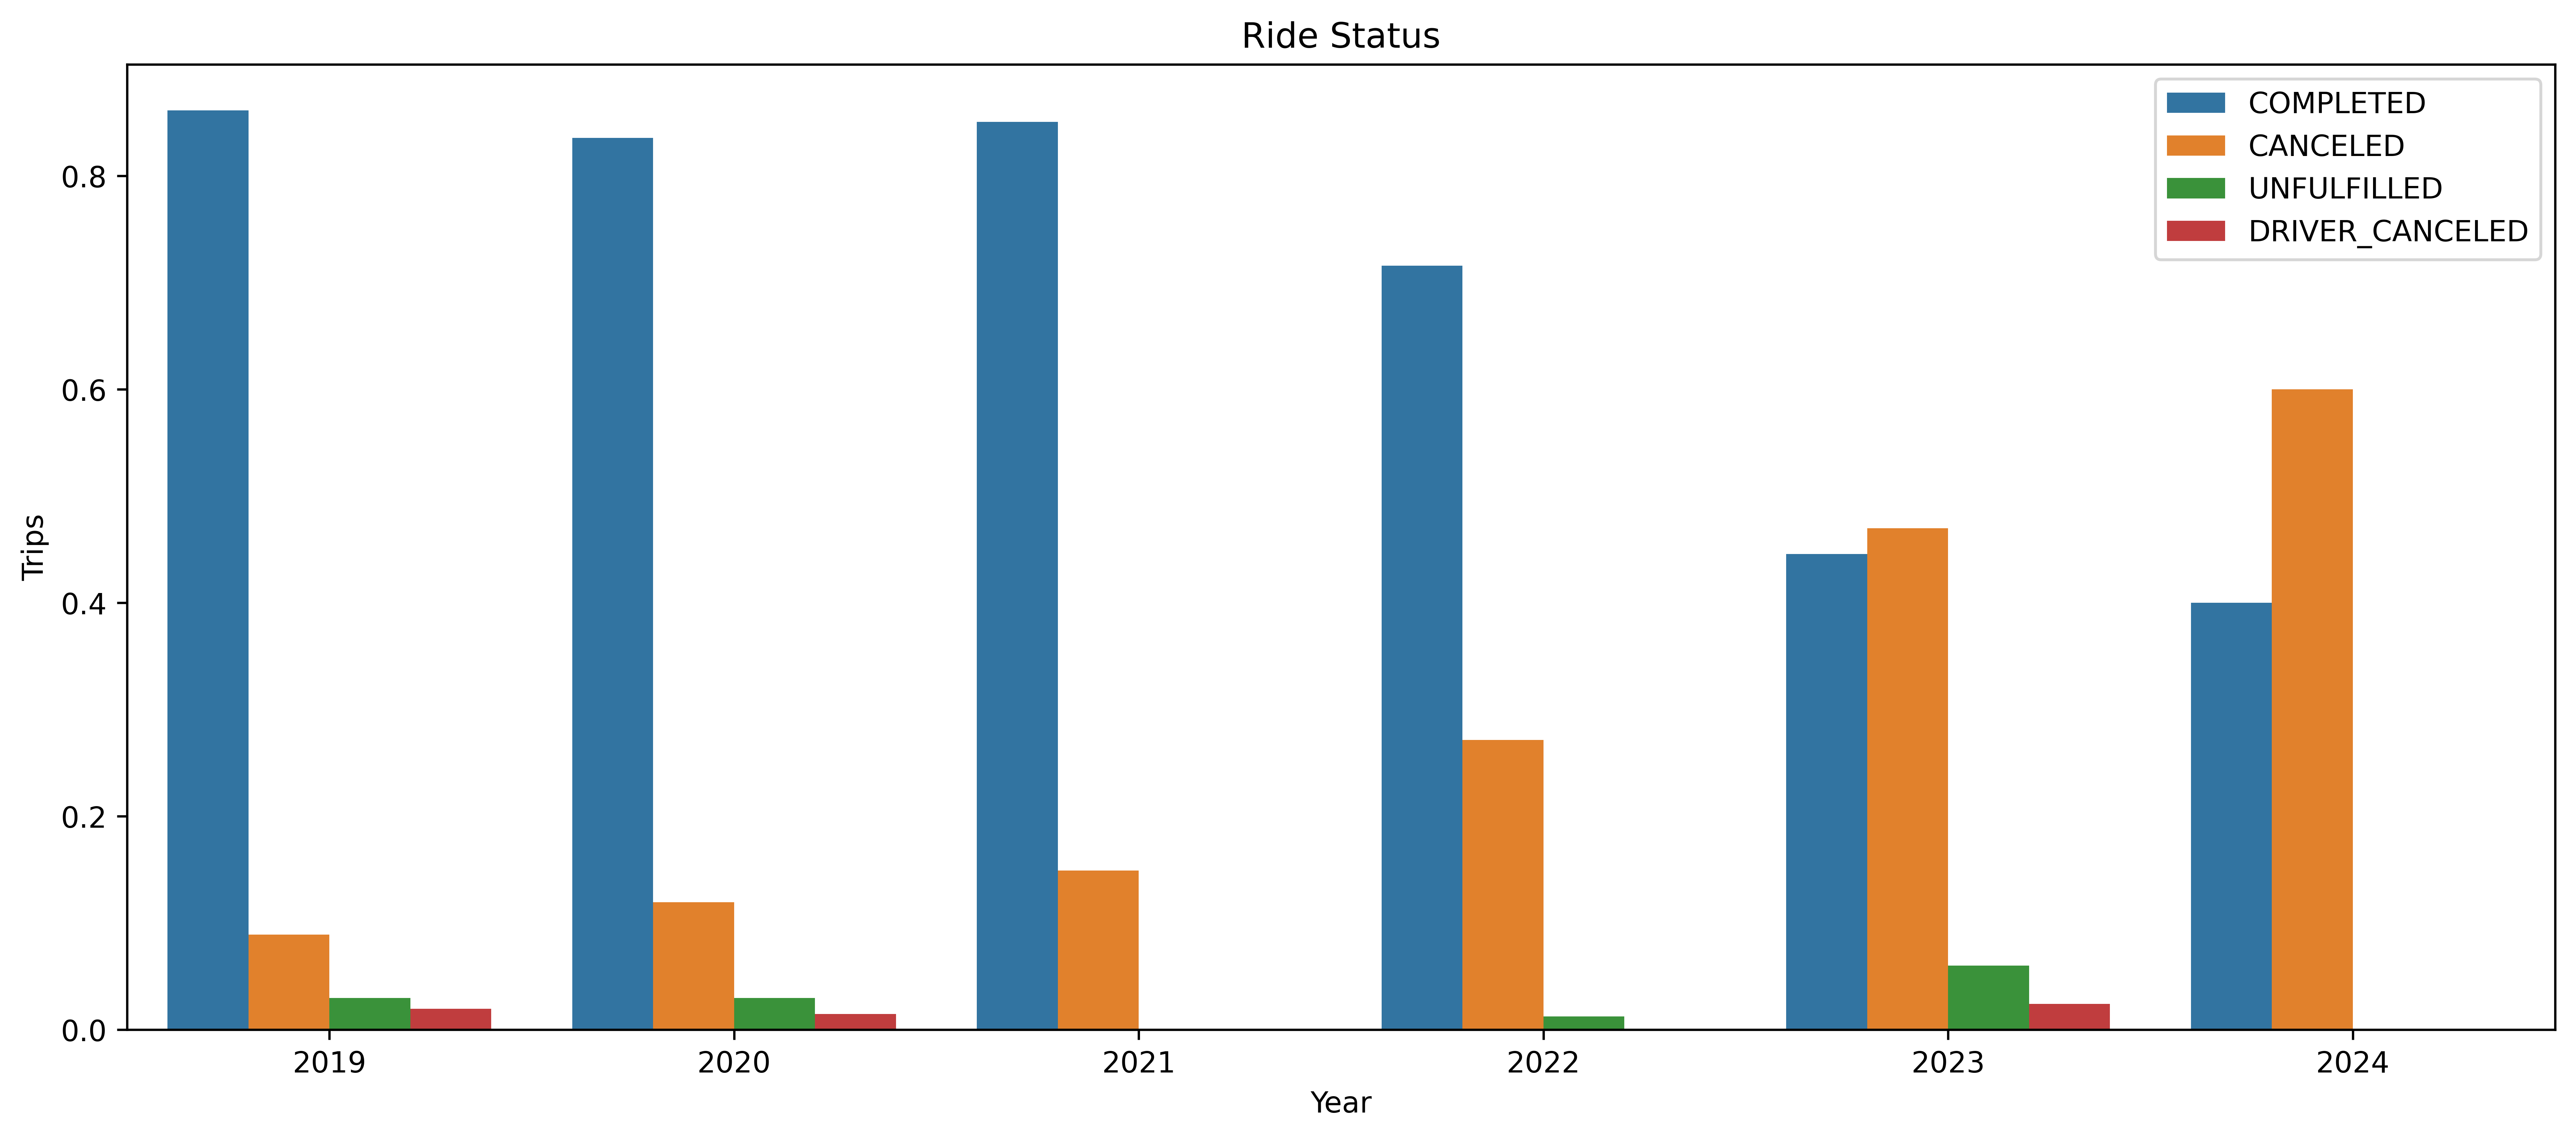

In [69]:
f, ax = plt.subplots(dpi = 600, figsize=(15, 6))
sns.barplot(
    x = 'Request Time',
    y= 'Frequency',
    hue = 'Ride Status',
    data = df_status,
    
)
plt.legend(loc = 'upper right')
plt.xlabel('Year')
plt.ylabel('Trips')
plt.title('Ride Status');

In 2023 and 2024, a higher number of rides were canceled.

**Monthly Ride Requests:** We have request date and the fare. If we can set the request date as an index we can turn it as a time series. We will resample it for months and then plot the fare paid and the count of requests.

In [70]:
# Creating a dataframe with two columns
df_a = df[['Request Time', 'Fare']].copy()

#Converting the Request Time as a datetime
df_a['Request Time'] = pd.to_datetime(df_a['Request Time'])

# Setting the index
df_a.set_index('Request Time', inplace=True)
df_a = df_a.sort_index()

# Resampling it for months
monthly_data = df_a.resample('M').agg(total_fare = ('Fare','sum'), 
             ride_requested = ('Fare', 'count'))

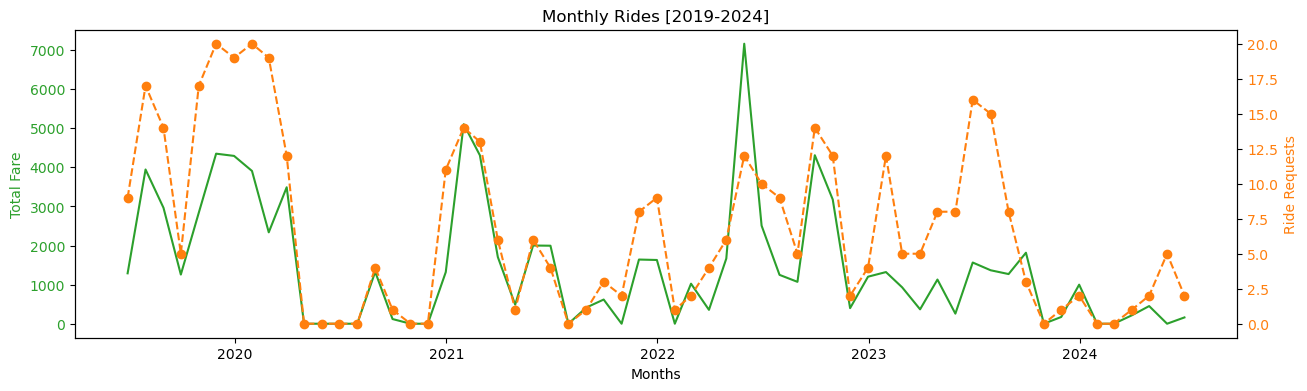

In [109]:
# Plotting two plots in the same graph
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.set_xlabel('Months')
ax1.set_ylabel('Total Fare', color = 'tab:green')
ax1.plot(monthly_data.index, monthly_data['total_fare'], color = 'tab:green')
ax1.tick_params(axis='y', labelcolor = 'tab:green')

ax2=ax1.twinx()
ax2.set_ylabel('Ride Requests',color = 'tab:orange')
ax2.plot(monthly_data.index, monthly_data['ride_requested'], color = 'tab:orange',marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor = 'tab:orange')

plt.title('Monthly Rides [2019-2024]')
plt.show();

**Trip Time:** When do I take more rides? Let's see that with a pie plot

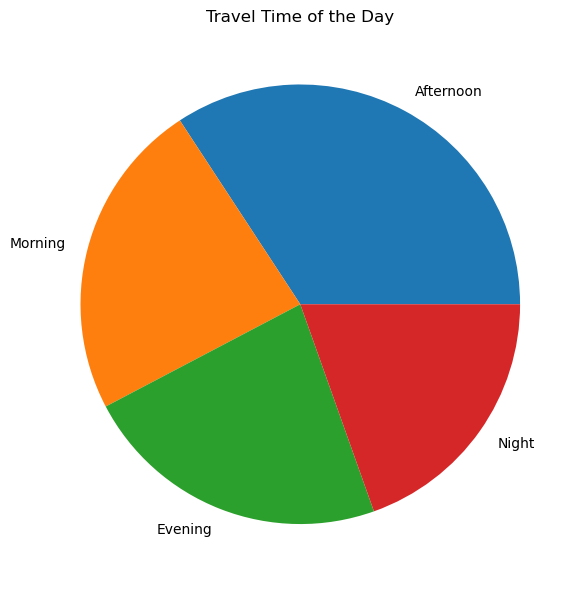

In [72]:
fig,ax= plt.subplots(figsize=(6,6))
df['Time of Trip'].value_counts(normalize=True).plot.pie(ax=ax, title = 'Travel Time of the Day', ylabel = '')
plt.tight_layout()
plt.show();

There is actually no favorite timing as seen from the graph.

**Favorite Route:** I want to put this analysis here to show how fares differ for a particular route with the same class of service. Becuase, you know, maybe a trip was too long due to traffic, maybe there was a promo code. Duration, distance, weather, promo all these affects the fare. Below, I presented some rides that were in the same route using the "Popular" service category. 

In [73]:
# Slicing the datafraome to extract relevant trip information

mask_drop = (df['Dropoff Address'] == 'A') | (df['Dropoff Address'] == 'B')
mask_pick = (df['Begin Trip Address'] == 'A') | (df['Begin Trip Address'] == 'B')
mask_p = df['Service'] == 'Popular'

df_transition = df[mask_drop & mask_pick]
df_special = df_transition[mask_p]
df_special[['Fare', 'Duration (Mins)', 'Distance (km)', 'Time of Trip']].set_index('Time of Trip').sort_index()

,Fare,Duration (Mins),Distance (km)
Time of Trip,,,
Afternoon,277.76,12.15,5.36
Afternoon,308.31,35.42,5.71
Afternoon,243.14,21.85,5.79
Evening,285.32,31.25,4.88
Evening,173.29,28.47,5.12
Morning,288.41,40.20,4.73
Morning,490.43,49.62,5.76
Night,214.42,22.13,5.81
Night,203.22,21.02,7.31


There is one Morning trip that costs a very high value becuase the duration was 50 minutes. 

**Service Category:** Popular, Economy and Premier are the three categories of services present in the market. I have another category here called 'Other', it is for the information with less-used requests, so I will not consider it. Also, I will calculate for completed rides only.

In [80]:
# Excluding the less used Service 
df_mask = df['Service'] !='Other'

# Considering the completed rides
df_status = df['Ride Status'] == 'COMPLETED'

#Creating the filtered dataframe
df_filtered = df [df_mask & df_status]

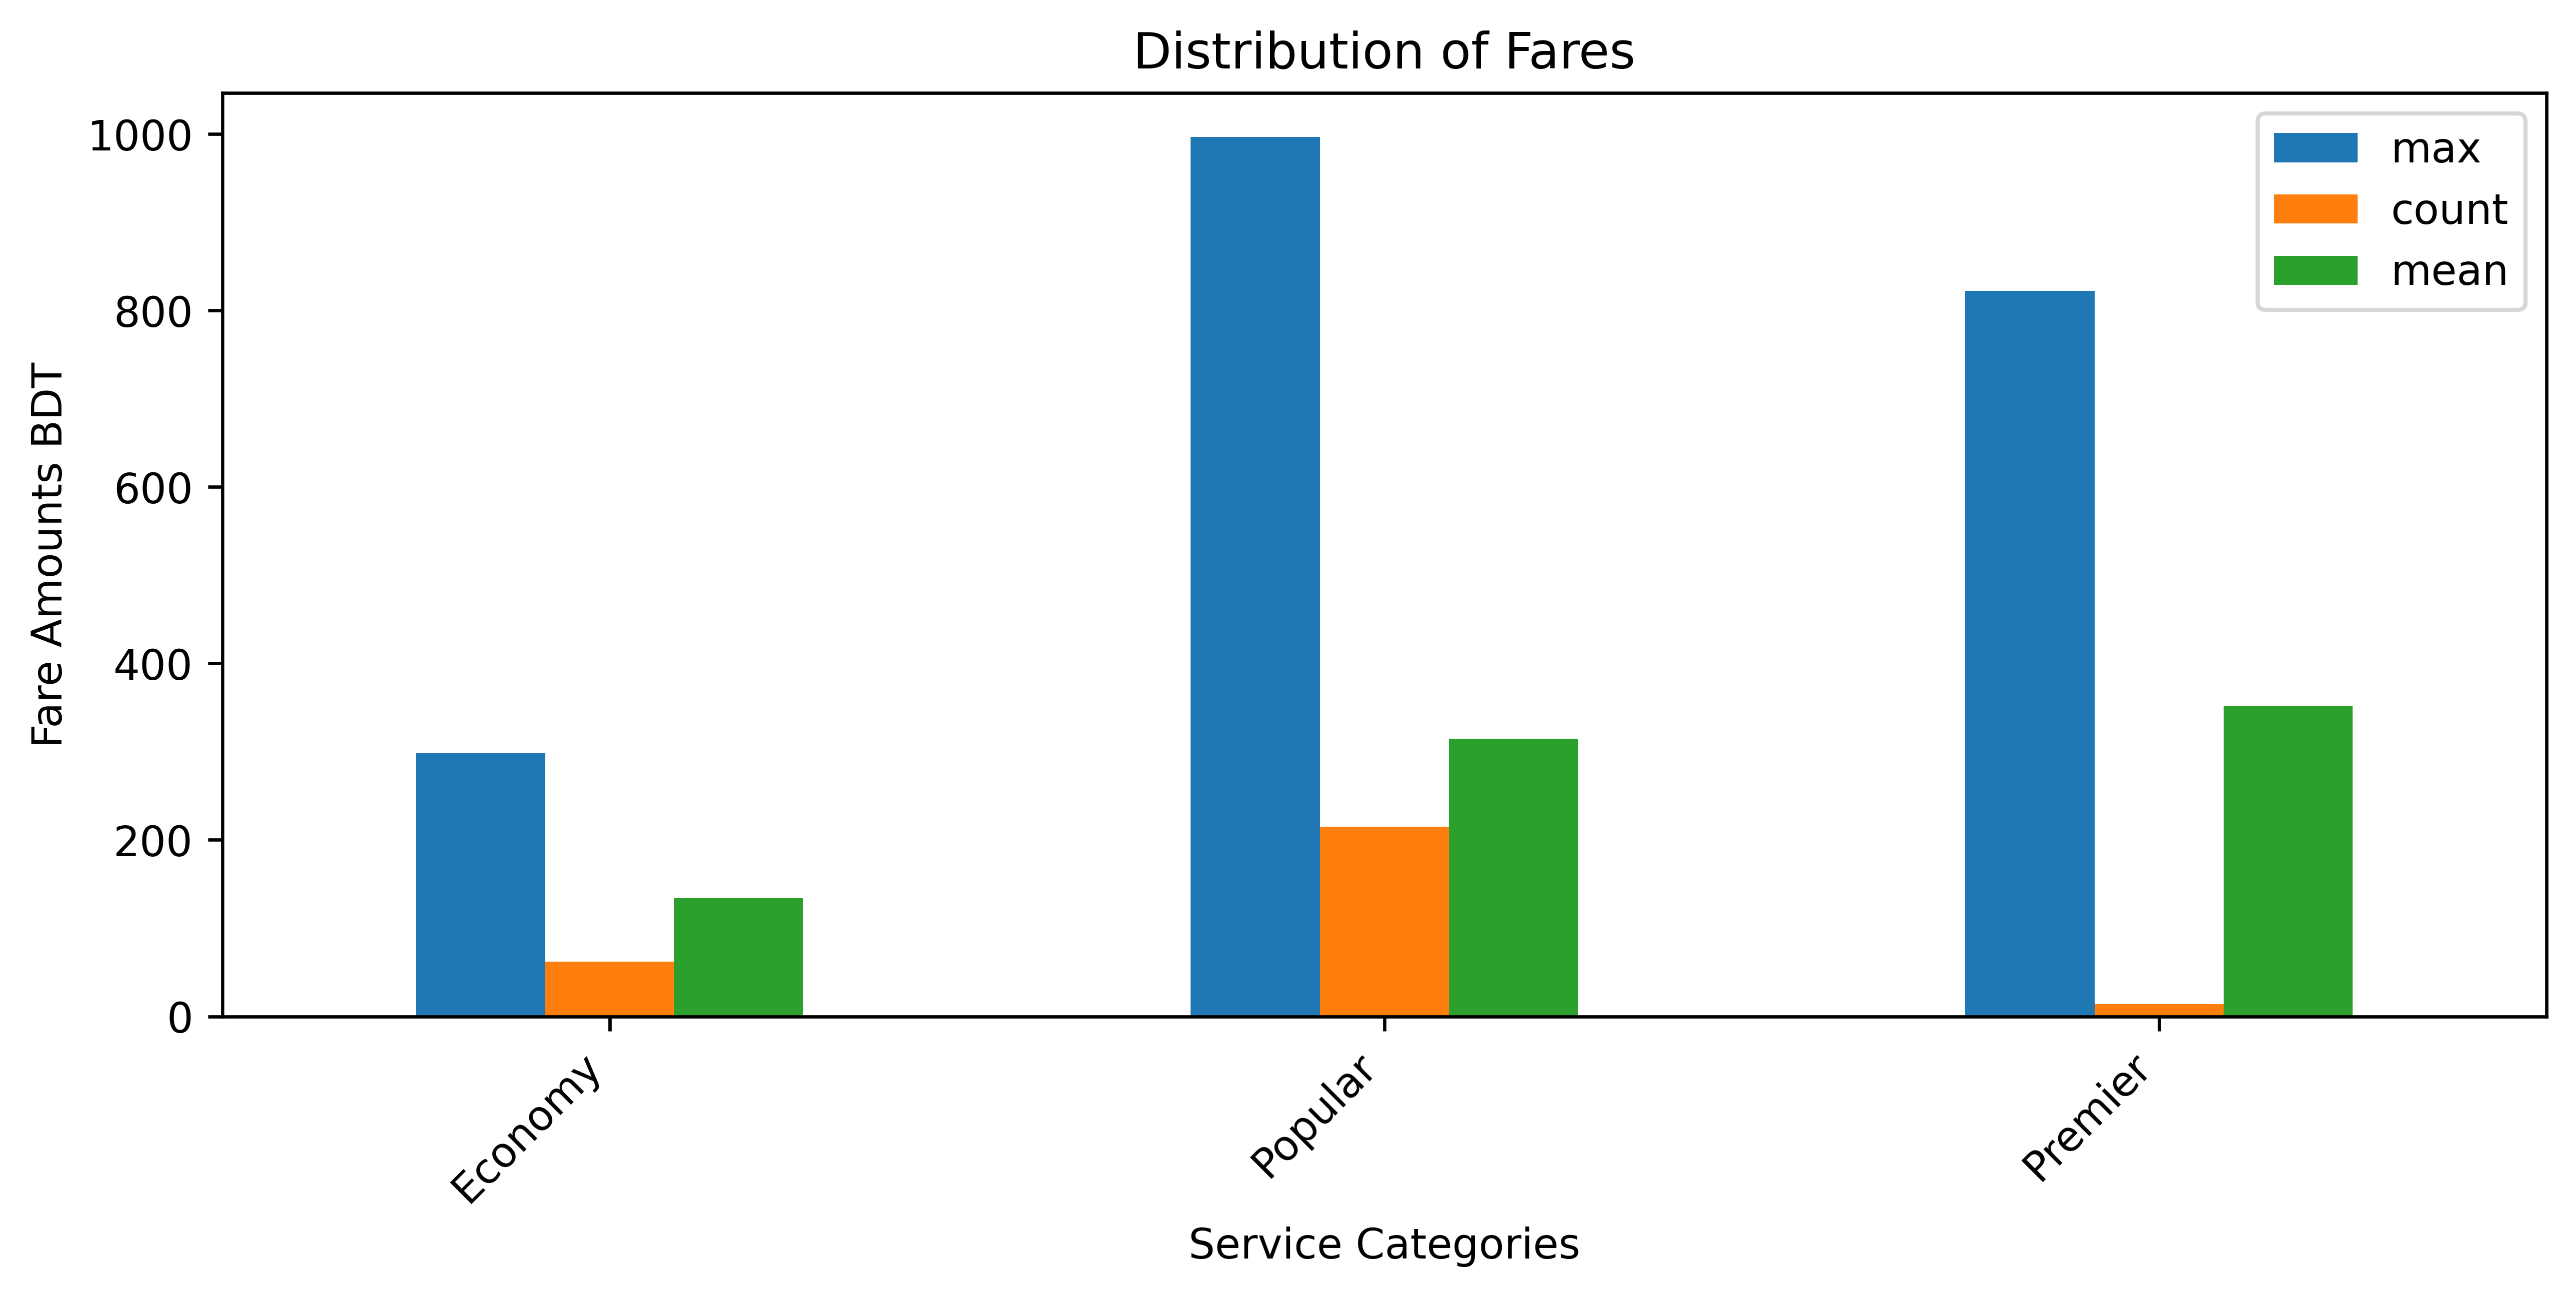

In [103]:
fig,ax = plt.subplots(dpi=600, figsize= (10,4))
(df_filtered
   .groupby('Service')
   .Fare
   .agg(['max','count', 'mean'])
).plot.bar(rot=45, ax=ax)
ax.set_xticklabels(labels=ax.get_xticklabels(), ha = 'right')
ax.legend(bbox_to_anchor=(1,1))
plt.xlabel('Service Categories')
plt.ylabel('Fare Amounts BDT')
plt.title('Distribution of Fares');

We're seeing the the mean, max and min fare for each category. But there is another powerful tool to see the distribution, that is boxplot.

**Boxplot:** Below I'm creating boxplots for the three categories.

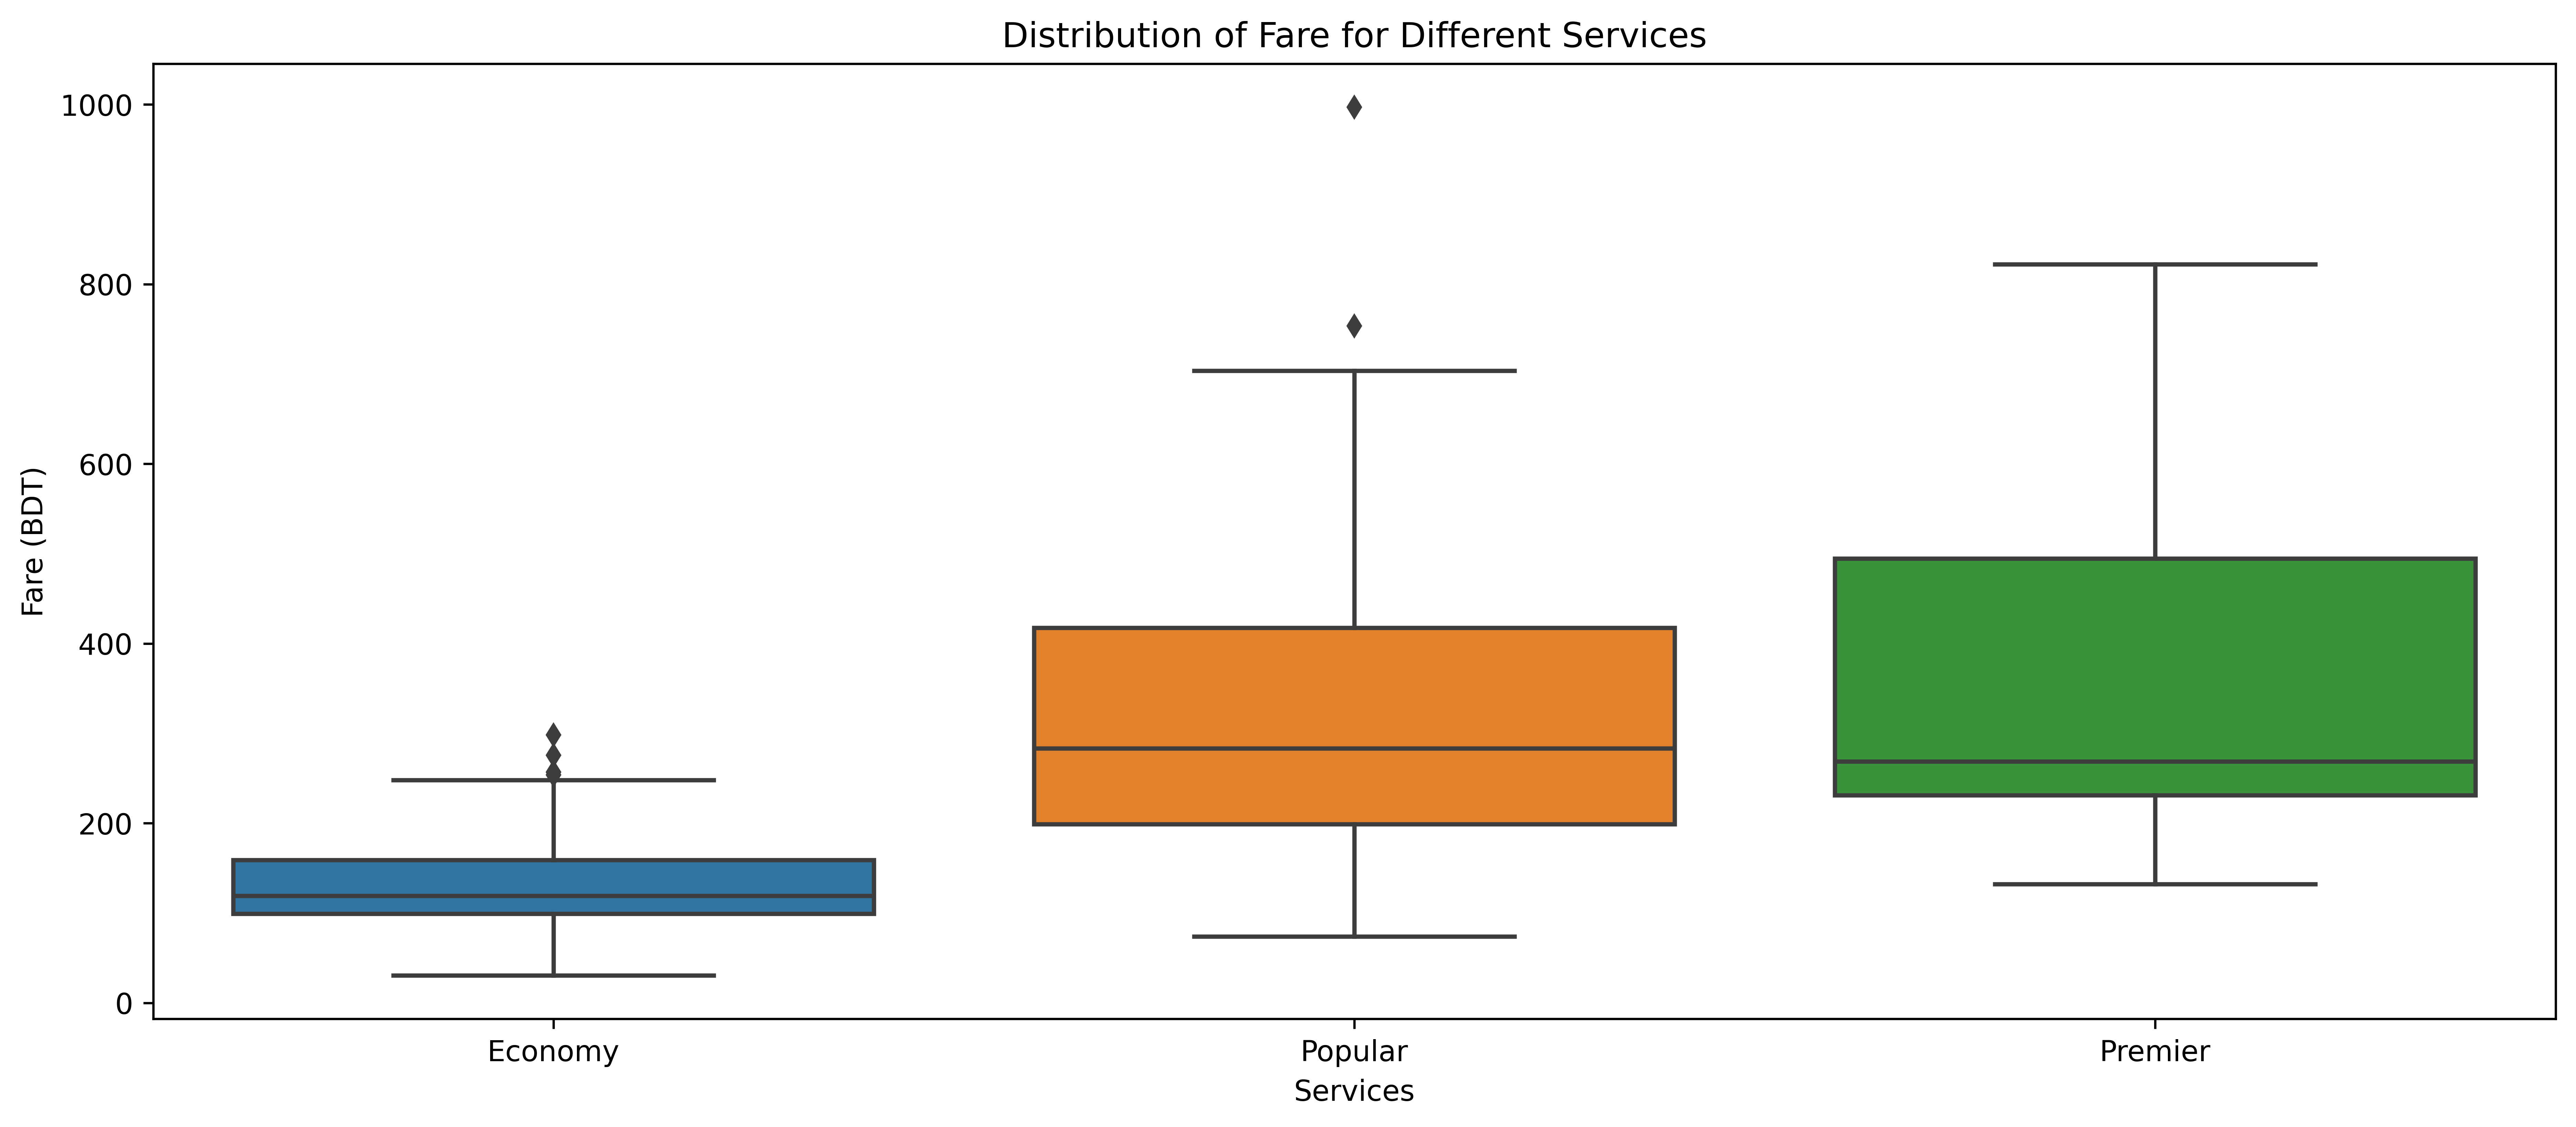

In [91]:
fig,ax = plt.subplots(dpi=600, figsize=(15, 6))
sns.boxplot(x="Service", y="Fare", data=df_filtered, ax=ax)
plt.xlabel("Services")
plt.ylabel("Fare (BDT)")
plt.title("Distribution of Fare for Different Services");

With Premier, 50% of rides are above 250 taka. We can see a couple of outliers present in the Popular and in the Economy category.

**Relation Between Fare, Distance and Service:** Using plotly, plot a scatter graph to show the relationship between Fare and Distance traveled. Use respective colors to indicate different services.

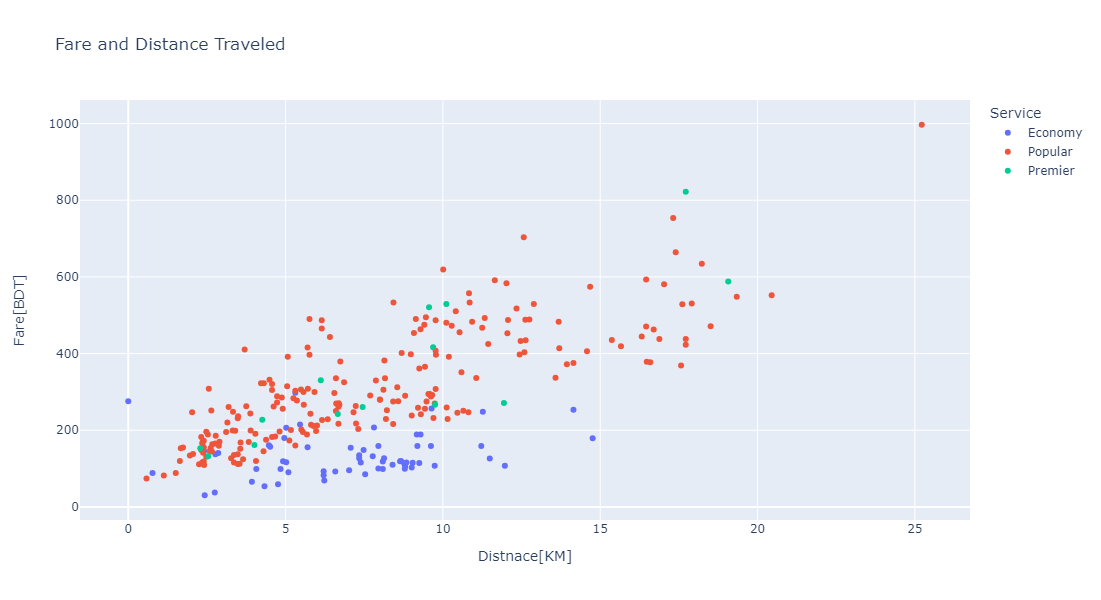

In [106]:
fig = px.scatter(
    data_frame=df_filtered,
    x="Distance (km)",
    y="Fare",
    color = "Service",
    title=" Fare and Distance Traveled",
    height=600

)
fig.update_layout(xaxis_title="Distnace[KM]", yaxis_title="Fare[BDT]")
fig.show()

The graph is dominated by the most Popular rides.